## Character Image Recognition - English Font-Number

In this notebook a model is created to make a prediction about which character the image is supposed to display

In [1]:
print("start")

start


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
import os

In [3]:
file_path_train = "/kaggle/input/english-fontnumber-recognition/train.csv"
df_chars = pd.read_csv(file_path_train)
df_chars

,filepaths,Font
0,../input/english-fontnumber-recognition/Font/F...,x
1,../input/english-fontnumber-recognition/Font/F...,x
2,../input/english-fontnumber-recognition/Font/F...,x
3,../input/english-fontnumber-recognition/Font/F...,x
4,../input/english-fontnumber-recognition/Font/F...,x
...,...,...
62987,../input/english-fontnumber-recognition/Font/F...,n
62988,../input/english-fontnumber-recognition/Font/F...,n
62989,../input/english-fontnumber-recognition/Font/F...,n
62990,../input/english-fontnumber-recognition/Font/F...,n


In [4]:
dir_path = "/kaggle/input/english-fontnumber-recognition/Font/Font"

validation_frac = 0.2
batch_size = 256

ds_train_ = image_dataset_from_directory(
    dir_path,
    labels='inferred',
    label_mode = 'categorical',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    subset="training",
    validation_split=validation_frac,
    seed=0
)

ds_valid_ = image_dataset_from_directory(
    dir_path,
    labels='inferred',
    label_mode = 'categorical',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    subset="validation",
    validation_split=validation_frac,
    seed=0
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 62992 files belonging to 62 classes.
Using 50394 files for training.
Found 62992 files belonging to 62 classes.
Using 12598 files for validation.


In [5]:
# Initialize lists to hold the data
X_val = []
y_val = []

# Iterate through the dataset
for image_batch, label_batch in ds_valid.as_numpy_iterator():
    X_val.append(image_batch)
    y_val.append(label_batch)

# Convert lists to NumPy arrays
X_val = np.concatenate(X_val, axis=0)
y_val = np.concatenate(y_val, axis=0)
y_val = np.argmax(y_val, axis=1)

print(X_val.shape, y_val.shape)

(12598, 128, 128, 3) (12598,)


In [6]:
model = keras.Sequential([
    layers.InputLayer(shape=[128, 128, 3]),
    
    # Data Augmentation
    layers.RandomContrast(factor=0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomZoom(height_factor=0.1, width_factor=0.1),

    # Block One
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_regularizer='l2'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_regularizer='l2'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.GlobalAveragePooling2D(),

    # Head
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu', kernel_regularizer='l2'),
    layers.Dropout(0.5),
    layers.Dense(62, activation='softmax'),
])

In [7]:
from tensorflow.keras.callbacks import EarlyStopping
import shutil

train_model = False

weights_path = "/kaggle/input/char-recognition-model/keras/default/4/char_recog_model_english_v2.weights.h5"
if os.path.isfile(weights_path) and not train_model:
    model.load_weights(weights_path)
    history = None

else:
    early_stopping = EarlyStopping(min_delta=0.001, patience=6, restore_best_weights=True)
    
    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    
    history = model.fit(
        ds_train,
        validation_data=(ds_valid),
        epochs=50,
        callbacks=[early_stopping]
    )

    model.save_weights("char_recog_model.weights.h5")
    shutil.move("char_recog_model.weights.h5", "/kaggle/working/char_recog_model.weights.h5")

In [8]:
import pandas as pd
if history is not None:
    history_frame = pd.DataFrame(history.history)
    history_frame.loc[:, ['loss', 'val_loss']].plot()
    history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [9]:
def plot_n_images(X, y, n=10, row_spacing=0.5):
    plt.figure(figsize=(10, 5))
    # Show the first n images if available, otherwise show all images
    for i in range(min(n, X.shape[0], y.shape[0])):  
        plt.subplot(n // 5 + 1, 5, i+1)
        plt.imshow(X[i], cmap='gray')  # Assuming 28x28 images
        plt.title(label_map[y[i]])
        plt.axis('off')

    plt.subplots_adjust(hspace=row_spacing)
    plt.show()

### Validation data same dataset accuracy

In [10]:
from sklearn.metrics import accuracy_score

predictions = model.predict(X_val)
predicted_labels = np.argmax(predictions, axis=1)

394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step


In [11]:
if len(y_val.shape) == 2:
    y_val_OH = y_val
    y_val = np.argmax(y_val_OH, axis=1)

accuracy = accuracy_score(y_val, predicted_labels)
accuracy

0.8602159072868709

In [12]:
from scipy.ndimage import gaussian_filter

def convert_to_grayscale(array):
    # shape (x, y, 3) --> (x, y)
    return np.dot(array[...,:3], [0.2989, 0.5870, 0.1140])

def apply_gaussian_filter(image):
    return gaussian_filter(image, sigma=1)

def crop_to_roi(image):
    rows = np.any(image > 0, axis=1)
    cols = np.any(image > 0, axis=0)
    row_start, row_end = np.where(rows)[0][[0, -1]]
    col_start, col_end = np.where(cols)[0][[0, -1]]
    return image[row_start:row_end+1, col_start:col_end+1]

def center_image(image, target_size=28, border=2):
    h, w = image.shape[:2]
    aspect_ratio = w / h

    # Calculate the new dimensions
    if aspect_ratio > 1:  # Wider than tall
        new_w = target_size[0] - 2 * border
        new_h = int(new_w / aspect_ratio)
    else:  # Taller than wide
        new_h = target_size[1] - 2 * border
        new_w = int(new_h * aspect_ratio)

    image = np.expand_dims(image, axis=-1)  # Add channel axis (shape -> (h, w, 1) )
    
    # Resize while preserving the aspect ratio
    image_resized = tf.image.resize(image, (new_h, new_w)).numpy()

    image_resized = np.squeeze(image_resized, axis=-1) # remove channel axis again
    
    # Create the centered canvas
    canvas = np.zeros(target_size, dtype=image.dtype)
    row_start = (target_size[0] - new_h) // 2
    col_start = (target_size[1] - new_w) // 2
    canvas[row_start:row_start+new_h, col_start:col_start+new_w] = image_resized

    return canvas


def normalize_image(image):
    return (image / np.max(image))


def preprocess_image(image, target_size=(28, 28)):
    if len(image.shape) == 3 and image.shape[2] >= 3:
        image = convert_to_grayscale(image)
    elif len(image.shape) == 3 and image.shape[2] == 1:
        image = np.squeeze(image, axis=-1)
        
    image = apply_gaussian_filter(image)
    image = crop_to_roi(image)
    image = center_image(image, target_size=target_size)
    image = normalize_image(image)
    return image.astype(np.float32)

In [13]:
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path, target_size=(128, 128), inverse=False):
    """
    Load an image and make it a numpy array.
    """
    # Load the image
    img = image.load_img(img_path, target_size=target_size)
    
    # Convert to an array
    img_array = image.img_to_array(img)

    # normalize to [0, 1]
    img_array = img_array / np.max(img_array)

    if inverse:
        img_array = 1 - img_array
    
    # Add a batch dimension (because the model expects a batch of images)
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

In [14]:
def load_and_preprocess_images_from_dir(dir_path, target_size=(28, 28), inverse=False):
    X = []
    for img in sorted(os.listdir(dir_path)):
        img_path = os.path.join(dir_path, img)
        if not os.path.isfile(img_path):
            continue
            
        img_array = load_and_preprocess_image(img_path, target_size=target_size, inverse=inverse)
        img_array = np.squeeze(img_array, axis=0)
        X.append(img_array)

    X = np.array(X)
    return X

In [15]:
def load_and_preprocess_all_image_classes_from_dir(dir_path, target_size=(28, 28), inverse=False):
    X = []
    y = []
    for img in sorted(os.listdir(dir_path)):
        img_path = os.path.join(dir_path, img)
        if not os.path.isfile(img_path):
            continue

        i = int(img[3:6]) - 1 # index starts at 0
        
        img_array = load_and_preprocess_image(img_path, target_size=target_size, inverse=inverse)
        img_array = np.squeeze(img_array, axis=0)
        X.append(img_array)
        y.append(i)

    X = np.array(X)
    y = np.array(y)
    return X, y

In [16]:
from string import ascii_lowercase, ascii_uppercase
alphabet_plus = "0123456789" + ascii_uppercase + ascii_lowercase
label_map = {i: alphabet_plus[i] for i in range(len(alphabet_plus))}


In [17]:
dir_path = "/kaggle/input/letters-and-digits/Images characters/"
dir_path_upper = "/kaggle/input/letters-and-digits/Images characters/Uppercase"
dir_path_lower = "/kaggle/input/letters-and-digits/Images characters/Lowercase"

img_path_zero = "/kaggle/input/letters-and-digits/Images characters/zero.png"
img_path_drawn_zero = "/kaggle/input/letters-and-digits/Images characters/drawn_zero.png"
img_path_drawn_M_close = "/kaggle/input/letters-and-digits/Images characters/M_handwritten_close.png"
img_path_drawn_M_far = "/kaggle/input/letters-and-digits/Images characters/M_handwritten_far.png"

(17, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
(17, 128, 128, 3) (17,)


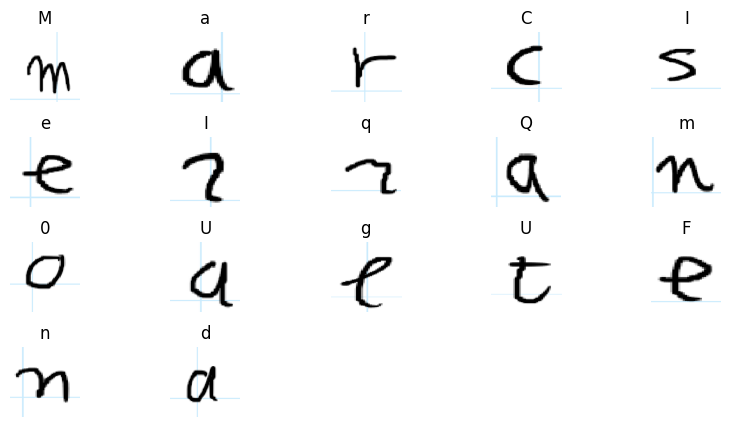

In [18]:
path = dir_path_lower
processed_images = load_and_preprocess_images_from_dir(path, target_size=(128, 128))
# processed_image = np.array([X_test[2]])

print(processed_images.shape)

# Make the prediction
predictions = model.predict(processed_images)

# For multi-class classification (e.g., 62 classes):
# Get the index of the class with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

print(processed_images.shape, predicted_classes.shape)
plot_n_images(processed_images, predicted_classes, n=17, row_spacing=0.5)

### English handwritten data accuracy

In [19]:
dir2_path = "/kaggle/input/english-handwritten-characters-dataset/Img"
X2, y2 = load_and_preprocess_all_image_classes_from_dir(dir2_path, target_size=(128, 128))

In [20]:
print(X2.shape, y2.shape)

(3410, 128, 128, 3) (3410,)


In [21]:
predictions_data2 = model.predict(X2)
predicted_labels2 = np.argmax(predictions_data2, axis=1)

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [22]:
accuracy = accuracy_score(y2, predicted_labels2)
accuracy

0.3750733137829912

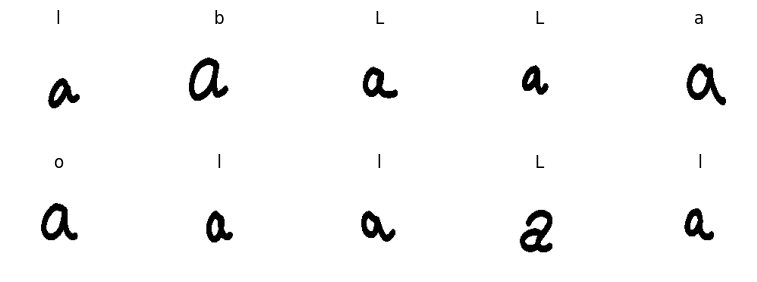

In [23]:
plot_n_images(X2[2000:], predicted_labels2[2000:])